In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import math
import time

In [2]:
def hough_inter(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[math.cos(theta1), math.sin(theta1)], 
                  [math.cos(theta2), math.sin(theta2)]])
    b = np.array([rho1, rho2])
    ans = np.linalg.lstsq(A, b, rcond=None)[0]
    return (int(ans[0]), int(ans[1]))
    

In [3]:
#Given theta in radians
def close_to_verticle(theta):
    #verticle lines are integer multiples of pi/2
    PI_2 = math.pi / 2
    
    num = (abs(theta) / PI_2)
    closest_pi_over_2 = round(num)
    
    threshold = 0.05
    if abs(num - closest_pi_over_2) < threshold:
        return True
    
#Given theta in radians
def close_to_horizontal(theta):
    #horizontal lines are integer multiples of pi
    PI = math.pi
    
    num = (abs(theta) / PI)
    closest_pi = round(num)
    
    threshold = 0.1
    if abs(num - closest_pi) < threshold:
        return True

In [4]:
#Finds the lines that bound the mast
#If image parameter is supplied, it will draw the lines on that image
#returns (r, theta) pairs in order of LTRB
def find_bounding_lines(edges, image = None):
    leftLine = None
    rightLine = None
    topLine = None
    bottomLine = None
    
    lines = cv2.HoughLines(edges, 1, np.pi/180, 60)
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr
        
        #check if lines are sortve vertical or sortve horizontal and then see if they beat the extremes
        if close_to_horizontal(theta):
            if not leftLine:
                leftLine = (r, theta)
            elif abs(r) < abs(leftLine[0]):
                leftLine = (r, theta)
            
            if not rightLine:
                rightLine = (r, theta)
            elif abs(r) > abs(rightLine[0]):
                rightLine = (r, theta)
        elif close_to_verticle(theta):
            if not topLine:
                topLine = (r, theta)
            elif abs(r) < abs(topLine[0]):
                topLine = (r, theta)
                
            if not bottomLine:
                bottomLine = (r, theta)
            elif abs(r) > abs(bottomLine[0]):
                bottomLine = (r, theta)
    
    return leftLine, topLine, rightLine, bottomLine #left top right bottom

In [32]:
#### FILTER ALGORITHM ####
def algorithm(frame = 25):
    image = cv2.imread('mast_imgs/frame_{}.jpg'.format(frame))
    image = image[300:-200, 800:-300, :] #simulatin depth filter of the camera
    print(image.shape)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)


    # Do HSV Thresholding
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([60,35,140])
    upper_blue = np.array([190,255,255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    result = cv2.bitwise_and(image, image, mask = mask)

    #Canny Edge Detection
    edges = cv2.Canny(result, 255/3, 255)

    lines = find_bounding_lines(edges=edges, image=None)

    left, top, right, bottom = lines

    #Display lines for debugging purposes
    for r, theta in lines:
        a = np.cos(theta); b = np.sin(theta)
        x0 = a*r; y0 = b*r
        x1 = int(x0 + 1000*(-b)); y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b)); y2 = int(y0 - 1000*(a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 10)

    TL_corner = hough_inter(top, left)
    TR_corner = hough_inter(top, right)
    BL_corner = hough_inter(bottom, left)
    BR_corner = hough_inter(bottom, right)

    cv2.circle(image, TL_corner, 10, 255, -1)
    cv2.circle(image, TR_corner, 10, 255, -1)
    cv2.circle(image, BL_corner, 10, 255, -1)
    cv2.circle(image, BR_corner, 10, 255, -1)
    
    
    #Plot Center 
    center = (int((TL_corner[0] + TR_corner[0] + BL_corner[0] + BR_corner[0])/4), int((TL_corner[1] + TR_corner[1] + BL_corner[1] + BR_corner[1])/4))
    cv2.circle(image, center, 5, (0, 120, 255), -1)
    
    return image

(580, 820, 3)


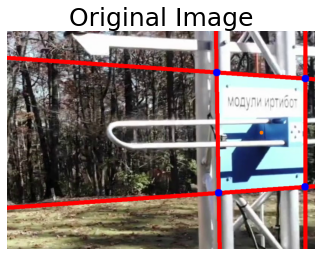

In [33]:
image = algorithm(frame = 30)
plt.imshow(image[:,:,::-1]);plt.title("Original Image",fontdict={'fontsize': 25});plt.axis('off');

In [ ]:
#Print Out Edged Image
plt.imshow(edges[:,:]);plt.title("Edged Image",fontdict={'fontsize': 25});plt.axis('off');

In [ ]:
# Solution 1 -- Vanishing point 

# Solution 2 -- Create matrix that maps the current points to a target set of points...